# Improved Hybrid CNN+MLP Training (V4.3 Enhanced) with Context Windows - aʊ̯/aː Phoneme Pair

**Enhanced version** with Focal Loss, SpecAugment, and improved architecture:

**Key improvements in V4.3:**
1. **Focal Loss**: Replaces LabelSmoothingCrossEntropy to focus on hard examples (70%+ high-confidence errors)
2. **SpecAugment**: Frequency and time masking for spectrogram augmentation during training
3. **Enhanced Architecture**:
   - Multi-head attention in cross-attention fusion (with dropout)
   - Residual connections in MLP branch
   - Enhanced SE blocks in CNN branch
4. **Code improvements**:
   - Fixed file loading duplication
   - Optimized data loading and processing
   - Added error handling and validation
   - Improved reproducibility with seed setting
   - Vectorized operations for better performance
   - **Modular code structure**: Common classes and functions imported from `hybrid_model_utils.py`

**Expected improvements:**
- Better handling of hard examples (Focal Loss)
- Improved generalization (SpecAugment)
- Better feature fusion (Multi-head attention with dropout)
- More stable training (Residual connections)
- Better code quality and maintainability


In [1]:
import sys
from pathlib import Path
import torch
import json
import pandas as pd
import numpy as np
import h5py
import joblib
import logging
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Import common utilities from shared module
from hybrid_model_utils import (
    set_seed,
    SpecAugment,
    HybridDataset,
    HybridCNNMLP_V4_3,
    FocalLoss,
    WarmupCosineScheduler,
    train_epoch,
    validate,
    train_model,
    evaluate_model
)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set seed for reproducibility
set_seed(42)
logger.info("Random seed set to 42 for reproducibility")

# Configuration
CONFIG = {
    'specaugment': {
        'F': 27,
        'T': 40,
        'm_F': 2,
        'm_T': 2
    },
    'training': {
        'batch_size': 64,
        'num_epochs': 200,
        'warmup_epochs': 5,
        'initial_lr': 5e-4,
        'min_lr': 1e-6,
        'weight_decay': 1e-4,
        'dropout': 0.4,
        'max_grad_norm': 1.0,
        'early_stopping_patience': 10
    },
    'focal_loss': {
        'alpha': 0.25,
        'gamma': 2.0
    }
}

# Project root
PROJECT_ROOT = Path('/Volumes/SSanDisk/SpeechRec-German')

# Data directory (with context v2 - includes VOT, burst features)
DATA_DIR = PROJECT_ROOT / 'artifacts' / 'aʊ̯-aː_dl_models_with_context_v2'
FEATURES_DIR = DATA_DIR / 'features'

# Validate directories exist
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
if not FEATURES_DIR.exists():
    raise FileNotFoundError(f"Features directory not found: {FEATURES_DIR}")

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
    logger.info("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    logger.info("Using CUDA device")
else:
    device = torch.device("cpu")
    logger.info("Using CPU device")

logger.info(f"Data directory: {DATA_DIR}")
logger.info(f"Features directory: {FEATURES_DIR}")


2026-01-04 23:00:56,561 - INFO - Random seed set to 42 for reproducibility
2026-01-04 23:00:56,598 - INFO - Using MPS device
2026-01-04 23:00:56,599 - INFO - Data directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/aʊ̯-aː_dl_models_with_context_v2
2026-01-04 23:00:56,600 - INFO - Features directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/aʊ̯-aː_dl_models_with_context_v2/features


## Load Data with Context Windows (V2 - with VOT and Burst Features)


In [2]:
# Load feature columns
feature_cols_path = DATA_DIR / 'feature_cols.json'
if not feature_cols_path.exists():
    raise FileNotFoundError(f"Feature columns file not found: {feature_cols_path}")
with open(feature_cols_path, 'r') as f:
    feature_cols = json.load(f)

# Load feature scaler
scaler_path = DATA_DIR / 'feature_scaler.joblib'
if not scaler_path.exists():
    raise FileNotFoundError(f"Scaler file not found: {scaler_path}")
feature_scaler = joblib.load(scaler_path)

# Load class weights
class_weights_path = DATA_DIR / 'class_weights.json'
if not class_weights_path.exists():
    raise FileNotFoundError(f"Class weights file not found: {class_weights_path}")
with open(class_weights_path, 'r') as f:
    class_weights_dict = json.load(f)

# Load features DataFrame (from 02.2 - includes VOT, burst features)
features_path = FEATURES_DIR / 'features.parquet'
if not features_path.exists():
    raise FileNotFoundError(f"Features file not found: {features_path}")
df = pd.read_parquet(features_path)
logger.info(f"Dataset shape: {df.shape}")
logger.info(f"Feature columns (loaded): {len(feature_cols)}")

# Filter feature_cols to only include columns that exist in DataFrame
original_feature_cols = feature_cols.copy()  # Save original before filtering
original_feature_count = len(feature_cols)
feature_cols = [col for col in feature_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

if len(feature_cols) != original_feature_count:
    missing_cols = set(original_feature_cols) - set(feature_cols)
    logger.warning(f"{original_feature_count - len(feature_cols)} feature columns are missing from DataFrame")
    if missing_cols:
        logger.warning(f"Missing columns: {list(missing_cols)[:10]}...")
        
    if 'duration_ms_features' in missing_cols:
        logger.info("Note: 'duration_ms_features' is missing - this is expected if duration_ms wasn't duplicated during merge.")
        logger.info("      This column is not a real feature and can be safely ignored.")

logger.info(f"Feature columns (filtered): {len(feature_cols)}")

# Verify feature count matches scaler
if hasattr(feature_scaler, 'n_features_in_'):
    if len(feature_cols) != feature_scaler.n_features_in_:
        logger.warning(f"Feature count mismatch. Scaler expects {feature_scaler.n_features_in_} features, but we have {len(feature_cols)}")
        logger.info("This is OK if some features were removed from the dataset. The scaler will be retrained on available features.")

# Check what metadata columns we have
metadata_cols = ['phoneme_id', 'class', 'duration_ms', 'phoneme', 'utterance_id']
present_metadata = [col for col in metadata_cols if col in df.columns]
logger.info(f"Metadata columns present: {present_metadata}")

# Handle class column
if 'class' not in df.columns:
    if 'phoneme' in df.columns:
        df['class'] = df['phoneme']
        logger.info("Created 'class' column from 'phoneme'")
    else:
        raise ValueError("Neither 'class' nor 'phoneme' column found in features.parquet.")

# Filter to only aw and aː classes
if not df['class'].isin(['aw', 'aː']).all():
    df = df[df['class'].isin(['aw', 'aː'])].copy()
    logger.info(f"Dataset after filtering to aw/aː: {len(df)} samples")

# Encode target
le = LabelEncoder()
df['class_encoded'] = le.fit_transform(df['class'])  # aw=0, aː=1
class_encoding = dict(zip(le.classes_, le.transform(le.classes_)))
logger.info(f"Class encoding: {class_encoding}")
logger.info(f"Class distribution:\n{df['class'].value_counts()}")

# Load split indices
split_indices_path = DATA_DIR / 'split_indices.json'
if not split_indices_path.exists():
    raise FileNotFoundError(f"Split indices file not found: {split_indices_path}")
with open(split_indices_path, 'r') as f:
    split_indices = json.load(f)

# Reset index
df = df.reset_index(drop=True)

# Create split column based on indices
df['split'] = 'train'
if len(df) > max(split_indices['val'] + split_indices['test']):
    df.loc[split_indices['val'], 'split'] = 'val'
    df.loc[split_indices['test'], 'split'] = 'test'
else:
    logger.warning("Split indices may not match DataFrame indices. Using phoneme_id matching...")
    val_ids = set(df.loc[split_indices['val'], 'phoneme_id'].values) if len(df) > max(split_indices['val']) else set()
    test_ids = set(df.loc[split_indices['test'], 'phoneme_id'].values) if len(df) > max(split_indices['test']) else set()
    df.loc[df['phoneme_id'].isin(val_ids), 'split'] = 'val'
    df.loc[df['phoneme_id'].isin(test_ids), 'split'] = 'test'

logger.info(f"Split distribution:\n{df['split'].value_counts()}")

# Load spectrograms with error handling
spectrograms_path = FEATURES_DIR / 'spectrograms.h5'
if not spectrograms_path.exists():
    raise FileNotFoundError(f"Spectrograms file not found: {spectrograms_path}")

spectrograms_dict = {}
try:
    with h5py.File(spectrograms_path, 'r') as f:
        phoneme_ids = list(f.keys())
        for phoneme_id in tqdm(phoneme_ids, desc="Loading spectrograms"):
            try:
                spectrograms_dict[phoneme_id] = f[phoneme_id][:]
            except Exception as e:
                logger.warning(f"Failed to load spectrogram for {phoneme_id}: {e}")
                continue
except Exception as e:
    raise RuntimeError(f"Failed to load spectrograms: {e}")

logger.info(f"Loaded {len(spectrograms_dict):,} spectrograms")
if spectrograms_dict:
    sample_shape = list(spectrograms_dict.values())[0].shape
    logger.info(f"Spectrogram shape: {sample_shape}")

# Filter to only phonemes with spectrograms
df['phoneme_id_str'] = df['phoneme_id'].astype(str)
df['has_spectrogram'] = df['phoneme_id_str'].isin(spectrograms_dict.keys())
df = df[df['has_spectrogram']].copy()
logger.info(f"Dataset after filtering for spectrograms: {len(df)} samples")


/Volumes/SSanDisk/SpeechRec-German/venv_pytorch/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2026-01-04 23:00:57,191 - INFO - Dataset shape: (39681, 134)
2026-01-04 23:00:57,193 - INFO - Feature columns (loaded): 130
2026-01-04 23:00:57,199 - WARNING - 1 feature columns are missing from DataFrame
2026-01-04 23:00:57,200 - WARNING - Missing columns: ['duration_ms_features']...
2026-01-04 23:00:57,202 - INFO - Note: 'duration_ms_features' is missing - this is expected if duration_ms wasn't duplicated during merge.
2026-01-04 23:00:57,204 - INFO -       This column is not a real feature and can be safely ignored.
2026-01-04 23:00:57,206 - INFO - Feature colu

## Create Dataset Classes with SpecAugment


In [3]:
# Check and retrain scaler if needed

train_df = df[df['split'] == 'train'].reset_index(drop=True)

train_feature_cols = [col for col in feature_cols if col in train_df.columns and pd.api.types.is_numeric_dtype(train_df[col])]

feature_cols = train_feature_cols



if hasattr(feature_scaler, 'n_features_in_') and len(feature_cols) != feature_scaler.n_features_in_:

    logger.info(f"Feature count mismatch detected: {len(feature_cols)} features in DataFrame vs {feature_scaler.n_features_in_} in scaler")

    logger.info("Retraining scaler on train split with current features...")

    X_train_features = train_df[feature_cols].values.astype(np.float32)

    X_train_features = np.nan_to_num(X_train_features, nan=0.0, posinf=0.0, neginf=0.0)

    feature_scaler = StandardScaler()

    feature_scaler.fit(X_train_features)

    logger.info(f"Scaler retrained on {len(feature_cols)} features")

else:

    logger.info(f"Using existing scaler with {feature_scaler.n_features_in_} features")



# Create datasets with SpecAugment for training

train_hybrid_ds = HybridDataset(

    df, spectrograms_dict, feature_cols, 

    scaler=feature_scaler, split='train', 

    use_specaugment=True, 

    specaug_config=CONFIG['specaugment']

)

val_hybrid_ds = HybridDataset(

    df, spectrograms_dict, feature_cols, 

    scaler=feature_scaler, split='val', 

    use_specaugment=False

)

test_hybrid_ds = HybridDataset(

    df, spectrograms_dict, feature_cols, 

    scaler=feature_scaler, split='test', 

    use_specaugment=False

)



logger.info(f"Train dataset: {len(train_hybrid_ds)} samples (with SpecAugment)")

logger.info(f"Val dataset: {len(val_hybrid_ds)} samples")

logger.info(f"Test dataset: {len(test_hybrid_ds)} samples")



# Check class imbalance and decide whether to apply balancing

IMBALANCE_THRESHOLD = 0.25  # 25% imbalance threshold

train_class_counts = train_df['class'].value_counts()

min_count = train_class_counts.min()

max_count = train_class_counts.max()

imbalance_ratio = 1.0 - (min_count / max_count)



logger.info(f"\nClass distribution in training set:")

for cls, count in train_class_counts.items():

    logger.info(f"  {cls}: {count} samples ({count/len(train_df)*100:.1f}%)")

logger.info(f"Imbalance ratio: {imbalance_ratio:.1%} (threshold: {IMBALANCE_THRESHOLD:.1%})")



if imbalance_ratio > IMBALANCE_THRESHOLD:

    # Apply balancing for significant imbalance

    logger.info(f"Significant class imbalance detected ({imbalance_ratio:.1%} > {IMBALANCE_THRESHOLD:.1%}), applying class balancing")

    use_class_balancing = True

    # Use class weights from file (computed with 'balanced' strategy)

    class_weights_array = np.array([class_weights_dict.get(str(i), class_weights_dict.get(i, 1.0)) for i in range(2)])

else:

    # Skip balancing for balanced or slightly imbalanced classes

    logger.info(f"Classes are balanced or slightly imbalanced ({imbalance_ratio:.1%} <= {IMBALANCE_THRESHOLD:.1%}), skipping class balancing")

    use_class_balancing = False

    # Use equal weights

    class_weights_array = np.array([1.0, 1.0])



# Create sampler based on imbalance check

train_labels = df[df['split'] == 'train']['class_encoded'].values

if use_class_balancing:

    sample_weights = np.array([class_weights_array[label] for label in train_labels])

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    logger.info(f"Using WeightedRandomSampler with class weights: {dict(zip(le.classes_, class_weights_array))}")

else:

    sampler = None  # Will use shuffle=True instead

    logger.info("Using standard DataLoader with shuffle=True (no class balancing)")



# Create DataLoaders

BATCH_SIZE = CONFIG['training']['batch_size']

if sampler is not None:
    train_hybrid_loader = DataLoader(train_hybrid_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
else:
    train_hybrid_loader = DataLoader(train_hybrid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_hybrid_loader = DataLoader(val_hybrid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_hybrid_loader = DataLoader(test_hybrid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



logger.info(f"Train batches: {len(train_hybrid_loader)}")

logger.info(f"Val batches: {len(val_hybrid_loader)}")

logger.info(f"Test batches: {len(test_hybrid_loader)}")



# Test a batch

sample_batch = next(iter(train_hybrid_loader))

logger.info(f"Sample batch - Spectrogram shape: {sample_batch[0][0].shape}, Features shape: {sample_batch[0][1].shape}, Labels shape: {sample_batch[1].shape}")



2026-01-04 23:01:11,318 - INFO - Feature count mismatch detected: 129 features in DataFrame vs 130 in scaler
2026-01-04 23:01:11,320 - INFO - Retraining scaler on train split with current features...
2026-01-04 23:01:11,656 - INFO - Scaler retrained on 129 features
2026-01-04 23:01:12,183 - INFO - Train dataset: 27791 samples (with SpecAugment)
2026-01-04 23:01:12,184 - INFO - Val dataset: 5937 samples
2026-01-04 23:01:12,185 - INFO - Test dataset: 5953 samples
2026-01-04 23:01:12,190 - INFO - 
Class distribution in training set:
2026-01-04 23:01:12,193 - INFO -   aː: 17887 samples (64.4%)
2026-01-04 23:01:12,195 - INFO -   aw: 9904 samples (35.6%)
2026-01-04 23:01:12,196 - INFO - Imbalance ratio: 44.6% (threshold: 25.0%)
2026-01-04 23:01:12,197 - INFO - Significant class imbalance detected (44.6% > 25.0%), applying class balancing
2026-01-04 23:01:12,226 - INFO - Using WeightedRandomSampler with class weights: {'aw': np.float64(1.4109971567831032), 'aː': np.float64(0.7744245666833863)

## Create Model and Training Configuration


In [4]:
# Create model V4.3 with automatic feature count detection

model = HybridCNNMLP_V4_3(

    n_features=len(feature_cols), 

    num_classes=2, 

    dropout=CONFIG['training']['dropout']

).to(device)



# Print model info

total_params = sum(p.numel() for p in model.parameters())

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

logger.info(f"Model: {model.get_config()['model_type']}")

logger.info(f"Total parameters: {total_params:,}")

logger.info(f"Trainable parameters: {trainable_params:,}")

logger.info(f"Number of features: {len(feature_cols)}")



# Prepare class weights for loss function
# Prepare class weights for loss function (use computed weights or equal weights)
class_weights = torch.tensor(class_weights_array, dtype=torch.float32).to(device)



# Loss function: Focal Loss with class weights

focal_config = CONFIG['focal_loss']

criterion = FocalLoss(

    alpha=focal_config['alpha'], 

    gamma=focal_config['gamma'], 

    weight=class_weights, 

    reduction='mean'

)



# Optimizer

train_config = CONFIG['training']

optimizer = torch.optim.Adam(

    model.parameters(), 

    lr=train_config['initial_lr'], 

    weight_decay=train_config['weight_decay']

)



# Learning rate scheduler with warmup and cosine annealing

scheduler = WarmupCosineScheduler(

    optimizer, 

    warmup_epochs=train_config['warmup_epochs'], 

    total_epochs=train_config['num_epochs'], 

    min_lr=train_config['min_lr']

)



# Output directory

OUTPUT_DIR = DATA_DIR / 'improved_models'

save_dir = OUTPUT_DIR / 'hybrid_cnn_mlp_v4_3_enhanced'

save_dir.mkdir(parents=True, exist_ok=True)



logger.info(f"\nTraining configuration:")

logger.info(f"- Epochs: {train_config['num_epochs']}")

logger.info(f"- Warmup epochs: {train_config['warmup_epochs']}")

logger.info(f"- Initial LR: {train_config['initial_lr']}")

logger.info(f"- Loss function: Focal Loss (alpha={focal_config['alpha']}, gamma={focal_config['gamma']})")

logger.info(f"- Gradient clipping: {train_config['max_grad_norm']}")

logger.info(f"- Early stopping patience: {train_config['early_stopping_patience']}")

logger.info(f"- Dropout: {train_config['dropout']}")

logger.info(f"- SpecAugment: Enabled for training")

logger.info(f"- Context windows: ±100ms (V2 with VOT and burst features)")

logger.info(f"- Save directory: {save_dir}")


2026-01-04 23:01:12,508 - INFO - Model: HybridCNNMLP_V4_3
2026-01-04 23:01:12,509 - INFO - Total parameters: 6,579,554
2026-01-04 23:01:12,510 - INFO - Trainable parameters: 6,579,554
2026-01-04 23:01:12,511 - INFO - Number of features: 129
2026-01-04 23:01:15,100 - INFO - 
Training configuration:
2026-01-04 23:01:15,101 - INFO - - Epochs: 200
2026-01-04 23:01:15,102 - INFO - - Warmup epochs: 5
2026-01-04 23:01:15,104 - INFO - - Initial LR: 0.0005
2026-01-04 23:01:15,106 - INFO - - Loss function: Focal Loss (alpha=0.25, gamma=2.0)
2026-01-04 23:01:15,107 - INFO - - Gradient clipping: 1.0
2026-01-04 23:01:15,109 - INFO - - Early stopping patience: 10
2026-01-04 23:01:15,110 - INFO - - Dropout: 0.4
2026-01-04 23:01:15,111 - INFO - - SpecAugment: Enabled for training
2026-01-04 23:01:15,115 - INFO - - Context windows: ±100ms (V2 with VOT and burst features)
2026-01-04 23:01:15,117 - INFO - - Save directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/aʊ̯-aː_dl_models_with_context_v2/impr

## Train Model


In [5]:
# Train model
train_config = CONFIG['training']
history, best_epoch = train_model(
    model, train_hybrid_loader, val_hybrid_loader, criterion, optimizer, scheduler,
    device, num_epochs=train_config['num_epochs'], save_dir=save_dir, 
    model_name='hybrid_cnn_mlp_v4_3_enhanced', 
    early_stopping_patience=train_config['early_stopping_patience'], 
    max_grad_norm=train_config['max_grad_norm']
)

# Load best model and evaluate on test set
checkpoint = torch.load(save_dir / 'best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
test_metrics, test_preds, test_labels, test_probs = evaluate_model(
    model, test_hybrid_loader, criterion, device
)

# Save test metrics
with open(save_dir / 'test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=2)

logger.info(f"\n{'='*60}")
logger.info(f"Final Test Results:")
logger.info(f"{'='*60}")
logger.info(f"Accuracy: {test_metrics['accuracy']:.4f}")
logger.info(f"F1-score: {test_metrics['f1']:.4f}")
logger.info(f"ROC-AUC: {test_metrics['roc_auc']:.4f}")
logger.info(f"Precision: {test_metrics['precision']:.4f}")
logger.info(f"Recall: {test_metrics['recall']:.4f}")
logger.info(f"Best epoch: {best_epoch}")


2026-01-04 23:01:15,144 - INFO - 
Epoch 1/200
2026-01-04 23:01:15,146 - INFO - --------------------------------------------------
2026-01-04 23:04:00,161 - INFO - Train Loss: 0.0089, Train Acc: 0.9499
2026-01-04 23:04:00,162 - INFO - Val Loss: 0.0031, Val Acc: 0.9847
2026-01-04 23:04:00,163 - INFO - Val F1: 0.9847, Val ROC-AUC: 0.9985
2026-01-04 23:04:00,164 - INFO - Learning Rate: 0.000100
2026-01-04 23:04:00,748 - INFO - ✓ New best model saved! (F1: 0.9847)
2026-01-04 23:04:00,750 - INFO - 
Epoch 2/200
2026-01-04 23:04:00,750 - INFO - --------------------------------------------------
2026-01-04 23:06:26,248 - INFO - Train Loss: 0.0049, Train Acc: 0.9767
2026-01-04 23:06:26,249 - INFO - Val Loss: 0.0029, Val Acc: 0.9865
2026-01-04 23:06:26,249 - INFO - Val F1: 0.9866, Val ROC-AUC: 0.9989
2026-01-04 23:06:26,249 - INFO - Learning Rate: 0.000200
2026-01-04 23:06:26,557 - INFO - ✓ New best model saved! (F1: 0.9866)
2026-01-04 23:06:26,557 - INFO - 
Epoch 3/200
2026-01-04 23:06:26,558 - 

## Save Predictions with Probabilities (Optimized with Vectorized Operations)


In [ ]:
# Get test dataset to extract phoneme metadata
test_df = df[df['split'] == 'test'].reset_index(drop=True)

# Get class names from label encoder
class_names = le.classes_

# Use vectorized operations instead of iterrows for better performance
# Ensure alignment between test_df and predictions
assert len(test_df) == len(test_labels) == len(test_preds) == len(test_probs), \
    f"Length mismatch: test_df={len(test_df)}, labels={len(test_labels)}, preds={len(test_preds)}, probs={len(test_probs)}"

# Convert to numpy arrays for vectorized comparison
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

# Create predictions dataframe using vectorized operations
predictions_data = {
    'phoneme_id': test_df['phoneme_id'].values,
    'utterance_id': test_df.get('utterance_id', pd.Series([None] * len(test_df))).values,
    'phoneme': test_df.get('phoneme', test_df.get('class', pd.Series([None] * len(test_df)))).values,
    'true_class': test_df['class'].values,
    'true_class_encoded': test_labels,
    'predicted_class_encoded': test_preds,
    'predicted_class': np.where(test_preds == 0, class_names[0], class_names[1]),  # aw=0, aː=1
    'prob_class_0': [p[0] for p in test_probs],
    'prob_class_1': [p[1] for p in test_probs],
    'max_prob': [np.max(p) for p in test_probs],
    'is_correct': (test_labels == test_preds).astype(int),
    'duration_ms': test_df.get('duration_ms', pd.Series([None] * len(test_df))).values
}

# Calculate confidence (max prob for correct, predicted prob for incorrect)
confidence = []
for i, (label, pred, prob) in enumerate(zip(test_labels, test_preds, test_probs)):
    if label == pred:
        confidence.append(float(np.max(prob)))
    else:
        confidence.append(float(prob[pred]))

predictions_data['confidence'] = confidence
predictions_df = pd.DataFrame(predictions_data)

# Save to CSV
predictions_df.to_csv(save_dir / 'test_predictions_with_probs.csv', index=False)
logger.info(f"Saved predictions with probabilities to: {save_dir / 'test_predictions_with_probs.csv'}")
logger.info(f"Total predictions: {len(predictions_df)}")
logger.info(f"Correct predictions: {predictions_df['is_correct'].sum()}")
logger.info(f"Incorrect predictions: {(~predictions_df['is_correct'].astype(bool)).sum()}")

# Save summary statistics
summary_stats = {
    'total_samples': len(predictions_df),
    'correct_predictions': int(predictions_df['is_correct'].sum()),
    'incorrect_predictions': int((~predictions_df['is_correct'].astype(bool)).sum()),
    'accuracy': float(predictions_df['is_correct'].mean()),
    'avg_confidence_correct': float(predictions_df[predictions_df['is_correct'] == 1]['confidence'].mean()),
    'avg_confidence_incorrect': float(predictions_df[predictions_df['is_correct'] == 0]['confidence'].mean()),
    'min_confidence_incorrect': float(predictions_df[predictions_df['is_correct'] == 0]['confidence'].min()),
    'max_confidence_incorrect': float(predictions_df[predictions_df['is_correct'] == 0]['confidence'].max()),
    'high_confidence_errors': int(((predictions_df['is_correct'] == 0) & (predictions_df['confidence'] > 0.8)).sum()),
    'low_confidence_errors': int(((predictions_df['is_correct'] == 0) & (predictions_df['confidence'] < 0.6)).sum()),
}

with open(save_dir / 'predictions_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

logger.info(f"\nSummary Statistics:")
logger.info(f"- Average confidence (correct): {summary_stats['avg_confidence_correct']:.4f}")
logger.info(f"- Average confidence (incorrect): {summary_stats['avg_confidence_incorrect']:.4f}")
logger.info(f"- High confidence errors (>0.8): {summary_stats['high_confidence_errors']}")
logger.info(f"- Low confidence errors (<0.6): {summary_stats['low_confidence_errors']}")


2026-01-04 23:50:06,799 - INFO - Saved predictions with probabilities to: /Volumes/SSanDisk/SpeechRec-German/artifacts/aʊ̯-aː_dl_models_with_context_v2/improved_models/hybrid_cnn_mlp_v4_3_enhanced/test_predictions_with_probs.csv
2026-01-04 23:50:06,800 - INFO - Total predictions: 5953
2026-01-04 23:50:06,801 - INFO - Correct predictions: 5901
2026-01-04 23:50:06,801 - INFO - Incorrect predictions: 52
2026-01-04 23:50:06,804 - INFO - 
Summary Statistics:
2026-01-04 23:50:06,804 - INFO - - Average confidence (correct): 0.9268
2026-01-04 23:50:06,805 - INFO - - Average confidence (incorrect): 0.6497
2026-01-04 23:50:06,805 - INFO - - High confidence errors (>0.8): 5
2026-01-04 23:50:06,805 - INFO - - Low confidence errors (<0.6): 19


## Save Validation Predictions


In [ ]:
# Get validation predictions
val_metrics, val_preds, val_labels, val_probs = evaluate_model(model, val_hybrid_loader, criterion, device)
val_df = df[df['split'] == 'val'].reset_index(drop=True)

# Get class names from label encoder
class_names = le.classes_

# Ensure alignment
assert len(val_df) == len(val_labels) == len(val_preds) == len(val_probs), \
    f"Length mismatch: val_df={len(val_df)}, labels={len(val_labels)}, preds={len(val_preds)}, probs={len(val_probs)}"

# Convert to numpy arrays for vectorized comparison
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

# Use vectorized operations
val_predictions_data = {
    'phoneme_id': val_df['phoneme_id'].values,
    'utterance_id': val_df.get('utterance_id', pd.Series([None] * len(val_df))).values,
    'phoneme': val_df.get('phoneme', val_df.get('class', pd.Series([None] * len(val_df)))).values,
    'true_class': val_df['class'].values,
    'true_class_encoded': val_labels,
    'predicted_class_encoded': val_preds,
    'predicted_class': np.where(val_preds == 0, class_names[0], class_names[1]),  # aw=0, aː=1
    'prob_class_0': [p[0] for p in val_probs],
    'prob_class_1': [p[1] for p in val_probs],
    'max_prob': [np.max(p) for p in val_probs],
    'is_correct': (val_labels == val_preds).astype(int),
    'duration_ms': val_df.get('duration_ms', pd.Series([None] * len(val_df))).values
}

# Calculate confidence
val_confidence = []
for i, (label, pred, prob) in enumerate(zip(val_labels, val_preds, val_probs)):
    if label == pred:
        val_confidence.append(float(np.max(prob)))
    else:
        val_confidence.append(float(prob[pred]))

val_predictions_data['confidence'] = val_confidence
val_predictions_df = pd.DataFrame(val_predictions_data)
val_predictions_df.to_csv(save_dir / 'val_predictions_with_probs.csv', index=False)
logger.info(f"Saved validation predictions to: {save_dir / 'val_predictions_with_probs.csv'}")


2026-01-04 23:50:10,815 - INFO - Saved validation predictions to: /Volumes/SSanDisk/SpeechRec-German/artifacts/aʊ̯-aː_dl_models_with_context_v2/improved_models/hybrid_cnn_mlp_v4_3_enhanced/val_predictions_with_probs.csv


## Confusion Matrix Analysis

Visualize confusion matrix to understand model errors per class

2026-01-04 23:50:11,554 - INFO - Confusion matrix saved to: /Volumes/SSanDisk/SpeechRec-German/artifacts/aʊ̯-aː_dl_models_with_context_v2/improved_models/hybrid_cnn_mlp_v4_3_enhanced/confusion_matrix.png


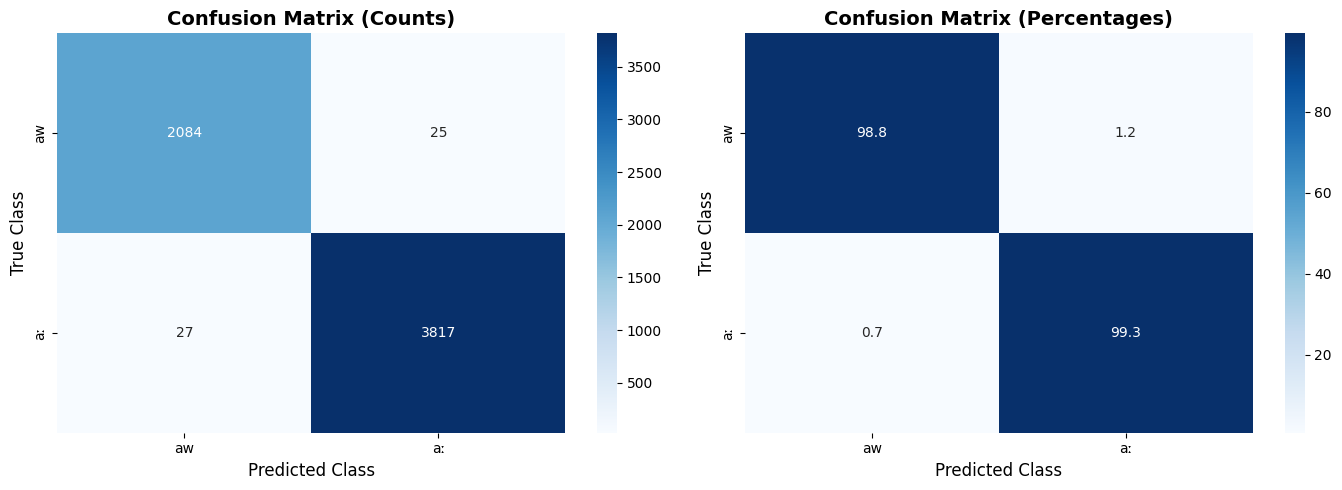

2026-01-04 23:50:11,598 - INFO - 
2026-01-04 23:50:11,599 - INFO - Confusion Matrix Analysis:
2026-01-04 23:50:11,599 - INFO - ============================================================
2026-01-04 23:50:11,599 - INFO - 
True Class: aw
2026-01-04 23:50:11,599 - INFO -   Total samples: 2109
2026-01-04 23:50:11,600 - INFO -   Correctly predicted: 2084 (98.81%)
2026-01-04 23:50:11,600 - INFO -   Incorrectly predicted: 25
2026-01-04 23:50:11,601 - INFO -     → Misclassified as 'aː': 25 (1.19%)
2026-01-04 23:50:11,601 - INFO - 
True Class: aː
2026-01-04 23:50:11,601 - INFO -   Total samples: 3844
2026-01-04 23:50:11,601 - INFO -   Correctly predicted: 3817 (99.30%)
2026-01-04 23:50:11,601 - INFO -   Incorrectly predicted: 27
2026-01-04 23:50:11,601 - INFO -     → Misclassified as 'aw': 27 (0.70%)
2026-01-04 23:50:11,602 - INFO - 
2026-01-04 23:50:11,602 - INFO - Overall Statistics:
2026-01-04 23:50:11,602 - INFO -   Total test samples: 5953
2026-01-04 23:50:11,602 - INFO -   Correct predic

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix for test set
cm = confusion_matrix(test_labels, test_preds)

# Get class names from label encoder
class_names = le.classes_

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion matrix with counts
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0]
)
axes[0].set_xlabel('Predicted Class', fontsize=12)
axes[0].set_ylabel('True Class', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Plot 2: Confusion matrix with percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt='.1f', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[1]
)
axes[1].set_xlabel('Predicted Class', fontsize=12)
axes[1].set_ylabel('True Class', fontsize=12)
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(save_dir / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
logger.info(f"Confusion matrix saved to: {save_dir / 'confusion_matrix.png'}")
plt.show()

# Print detailed statistics
logger.info(f"\n{'='*60}")
logger.info(f"Confusion Matrix Analysis:")
logger.info(f"{'='*60}")
for i, true_class in enumerate(class_names):
    total_true = cm[i].sum()
    correct = cm[i, i]
    errors = total_true - correct
    accuracy_per_class = (correct / total_true * 100) if total_true > 0 else 0
    
    logger.info(f"\nTrue Class: {true_class}")
    logger.info(f"  Total samples: {total_true}")
    logger.info(f"  Correctly predicted: {correct} ({accuracy_per_class:.2f}%)")
    logger.info(f"  Incorrectly predicted: {errors}")
    
    # Show error breakdown
    for j, pred_class in enumerate(class_names):
        if i != j and cm[i, j] > 0:
            error_pct = (cm[i, j] / total_true * 100) if total_true > 0 else 0
            logger.info(f"    → Misclassified as '{pred_class}': {cm[i, j]} ({error_pct:.2f}%)")

# Calculate overall metrics
total_samples = cm.sum()
correct_predictions = cm.trace()
total_errors = total_samples - correct_predictions

logger.info(f"\n{'='*60}")
logger.info(f"Overall Statistics:")
logger.info(f"  Total test samples: {total_samples}")
logger.info(f"  Correct predictions: {correct_predictions} ({correct_predictions/total_samples*100:.2f}%)")
logger.info(f"  Total errors: {total_errors} ({total_errors/total_samples*100:.2f}%)")
